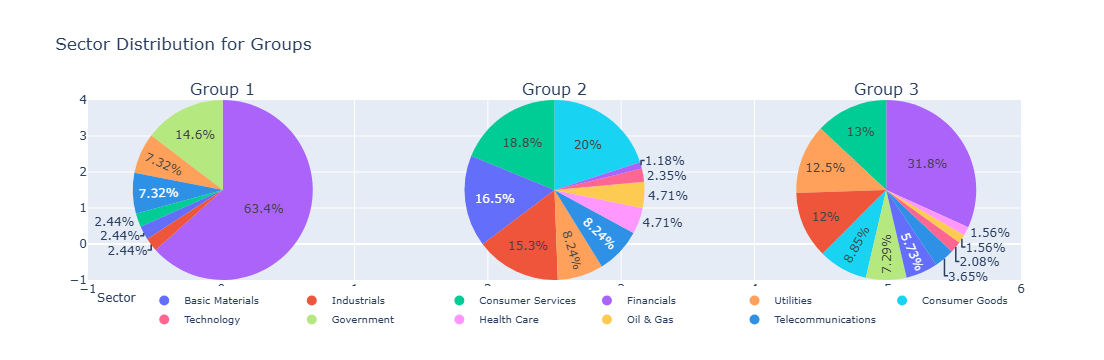

In [9]:
import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.colors as pc
from modified_spectral_method import recursive_spectral_method, create_correlation_matrix, calculate_C_g
from modified_louvain_method import *
from itertools import product
from collections import Counter

# Function to plot pie charts by user-selected criteria (sector, region, or country) using Plotly
def plot_group_distribution(groups, df, criteria='Sector'):
    
    unique_sectors = df['Sector'].unique()
    unique_regions = df['Region'].unique()
    unique_countries = df['Country'].unique()

    # Define a more distinguishable color palette
    color_palette = pc.qualitative.Plotly + pc.qualitative.Dark24 + pc.qualitative.Light24
    sector_colors = dict(zip(unique_sectors, color_palette[:len(unique_sectors)]))
    region_colors = dict(zip(unique_regions, color_palette[:len(unique_regions)]))
    country_colors = dict(zip(unique_countries, color_palette[:len(unique_countries)]))

    if criteria not in ['Sector', 'Region', 'Country']:
        raise ValueError("Invalid criteria! Use 'Sector', 'Region', or 'Country'.")

    color_dict_sector = {'Sector': sector_colors, 'Region': region_colors, 'Country': country_colors}
    color_dict = color_dict_sector[criteria]
    
    # Setting up the subplot grid
    num_groups = len(groups)
    ncols = 3  # Maximum of 3 columns
    nrows = (num_groups + ncols - 1) // ncols  # Calculate required rows based on number of groups
    fig = make_subplots(rows=nrows, cols=ncols, subplot_titles=[f'Group {i+1}' for i in range(num_groups)], specs=[[{'type': 'domain'}]*ncols]*nrows)
    
    # Add each group's pie chart to the subplots
    for idx, tickers in enumerate(groups):
        row = idx // ncols + 1
        col = idx % ncols + 1

        # Filter data for the current group
        group_data = df[df['Ticker'].isin(tickers)]

        # Count the occurrences of each sector, region, or country
        counts = group_data[criteria].value_counts()
        
        # Prepare colors for the pie chart
        colors = [color_dict[key] for key in counts.index]

        # Add the pie chart to the subplot
        fig.add_trace(go.Pie(labels=counts.index, values=counts, marker=dict(colors=colors), showlegend=False), row=row, col=col)

    # Create a legend manually at the bottom of the figure
    fig.update_layout(
        title_text=f"{criteria} Distribution for Groups",
        showlegend=True,
        legend=dict(
            title=criteria,
            orientation="h",
            yanchor="bottom",
            y=-0.3,  # Adjust to move legend up or down
            xanchor="center",
            x=0.5,
            font=dict(size=10)
        )
    )

    # Add dummy traces to populate the shared legend with colors
    for label, color in color_dict.items():
        fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color=color), name=label))

    fig.show()


if __name__ == '__main__':
    df = pd.read_csv('metadata.csv')
    correlation_matrix, T, N, company_names = create_correlation_matrix('eur_data_standardized_returns.csv')  
    C_g = calculate_C_g(correlation_matrix, T, N)
    result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

    plot_group_distribution(company_communities, df, criteria='Sector')

Plot saved to plots\group_distribution_with_legend.png


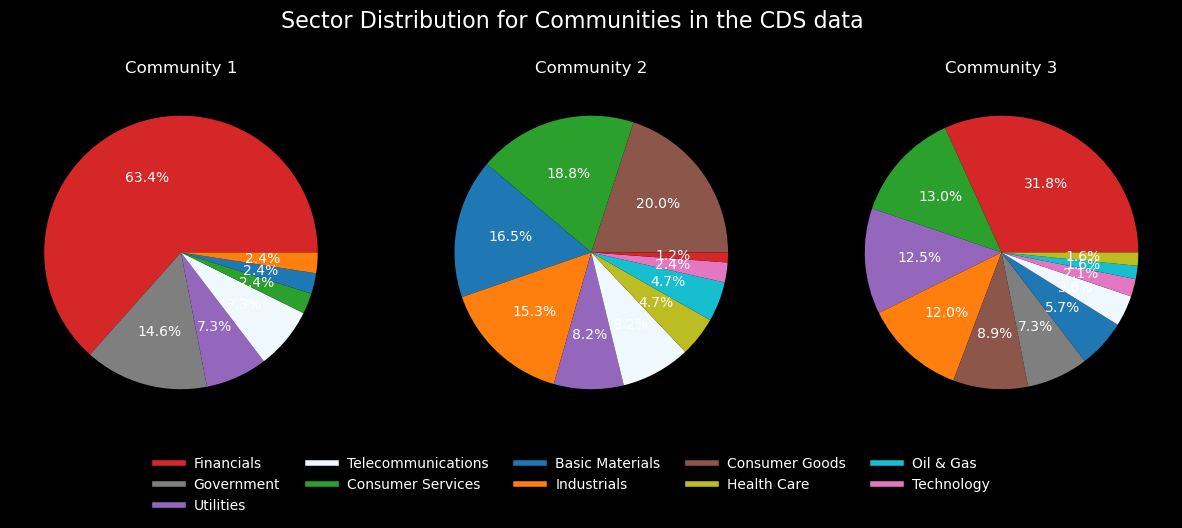

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import os
from itertools import cycle

def plot_group_distribution_with_legend(groups, df, criteria='Sector', save_path='plots', save_name='group_distribution_with_legend.png'):
    # Ensure save directory exists
    os.makedirs(save_path, exist_ok=True)

    unique_sectors = df['Sector'].unique()
    unique_regions = df['Region'].unique()
    unique_countries = df['Country'].unique()

    # Define a distinguishable color palette
    color_palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    sector_colors = dict(zip(unique_sectors, cycle(color_palette)))
    region_colors = dict(zip(unique_regions, cycle(color_palette)))
    country_colors = dict(zip(unique_countries, cycle(color_palette)))

    if criteria not in ['Sector', 'Region', 'Country']:
        raise ValueError("Invalid criteria! Use 'Sector', 'Region', or 'Country'.")

    color_dict_sector = {'Sector': sector_colors, 'Region': region_colors, 'Country': country_colors}
    color_dict = color_dict_sector[criteria]

    # Setting up the subplot grid
    num_groups = len(groups)
    ncols = 3  # Maximum of 3 columns
    nrows = (num_groups + ncols - 1) // ncols  # Calculate required rows based on number of groups
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5), facecolor='black')
    axes = axes.flatten()

    # Create a dictionary to track the legend elements
    legend_handles = []

    for idx, tickers in enumerate(groups):
        # Filter data for the current group
        group_data = df[df['Ticker'].isin(tickers)]

        # Count the occurrences of each sector, region, or country
        counts = group_data[criteria].value_counts()

        # Prepare colors for the pie chart
        colors = [color_dict[key] for key in counts.index]

        # Create pie chart with percentages
        wedges, texts, autotexts = axes[idx].pie(
            counts,
            colors=colors,
            autopct='%1.1f%%',  # Display percentages
            textprops={'color': 'white'}  # White text for readability
        )

        # Set title for the subplot
        axes[idx].set_title(f'Community {idx + 1}', color='white')

        # Add each wedge to the legend handles if not already included
        for label, wedge in zip(counts.index, wedges):
            if label not in [h.get_label() for h in legend_handles]:
                legend_handles.append(plt.Line2D([0], [0], color=wedge.get_facecolor(), lw=4, label=label))


    # Hide unused subplots
    for ax in axes[num_groups:]:
        ax.axis('off')

    # Add a centralized legend
    fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=10, frameon=False, title=criteria, title_fontsize=12, labelcolor="white")

    # Set a global title
    fig.suptitle(f'{criteria} Distribution for Communities in the CDS data', color='white', fontsize=16)

    # Save the plot
    file_path = os.path.join(save_path, save_name)
    plt.savefig(file_path, facecolor=fig.get_facecolor(), bbox_inches='tight')
    print(f"Plot saved to {file_path}")

    plt.show()


if __name__ == '__main__':
    df = pd.read_csv('metadata.csv')
    correlation_matrix, T, N, company_names = create_correlation_matrix('eur_data_standardized_returns.csv')  
    C_g = calculate_C_g(correlation_matrix, T, N)
    result_communities, company_communities, modularities = recursive_spectral_method(C_g, correlation_matrix, company_names, min_size=2, modularity_threshold=0.00001)

    # Use Matplotlib-based function with legend
    plot_group_distribution_with_legend(company_communities, df, criteria='Sector')


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Ensure the 'plots' directory exists
if not os.path.exists('plots'):
    os.makedirs('plots')

# Data from results
datasets = ['FTSE 100', 'S&P500']
methods = ['Louvain Method', 'Spectral Method']

# Extract modularity and number of communities for each dataset and method
modularity_scores = [
    results_FTSE['Modified Louvain']['Modularity'],
    results_FTSE['Recursive Spectral']['Modularity'],
    results['Modified Louvain']['Modularity'],
    results['Recursive Spectral']['Modularity']
]

community_counts = [
    results_FTSE['Modified Louvain']['Number of Communities'],
    results_FTSE['Recursive Spectral']['Number of Communities'],
    results['Modified Louvain']['Number of Communities'],
    results['Recursive Spectral']['Number of Communities']
]

# X-axis positions
x = np.arange(len(datasets))  # Number of datasets
width = 0.35  # Width of each bar

# **Modularity Bar Plot**
fig, ax = plt.subplots(figsize=(10, 6), facecolor='black')
ax.set_facecolor('black')

# Plot modularity
ax.bar(x - width/2, [modularity_scores[0], modularity_scores[2]], width, label='Louvain Method', color='green')
ax.bar(x + width/2, [modularity_scores[1], modularity_scores[3]], width, label='Spectral Method', color='cyan')

# Customize plot
ax.set_title('Modularity Comparison', fontsize=14, fontweight='bold', color='white')
ax.set_ylabel('Modularity', fontsize=12, color='white')
ax.set_xticks(x)
ax.set_xticklabels(datasets, fontsize=12, color='white')
ax.tick_params(axis='y', colors='white')  # Set y-axis tick labels to white
ax.legend(fontsize=10, facecolor='black', edgecolor='white', labelcolor='white')
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
for spine in ax.spines.values():
    spine.set_color('white')

# Save and show the plot
modularity_plot_path = os.path.join('plots', 'modularity_comparison.png')
plt.tight_layout()
plt.savefig(modularity_plot_path, dpi=300, facecolor=fig.get_facecolor())
plt.show()
print(f"Modularity plot saved to {modularity_plot_path}")

# **Number of Communities Bar Plot**
fig, ax = plt.subplots(figsize=(10, 6), facecolor='black')
ax.set_facecolor('black')

# Plot number of communities
ax.bar(x - width/2, [community_counts[0], community_counts[2]], width, label='Louvain Method', color='green')
ax.bar(x + width/2, [community_counts[1], community_counts[3]], width, label='Spectral Method', color='cyan')

# Customize plot
ax.set_title('Number of Communities Comparison', fontsize=14, fontweight='bold', color='white')
ax.set_ylabel('Number of Communities', fontsize=12, color='white')
ax.set_xticks(x)
ax.set_xticklabels(datasets, fontsize=12, color='white')
ax.tick_params(axis='y', colors='white')  # Set y-axis tick labels to white
ax.legend(fontsize=10, facecolor='black', edgecolor='white', labelcolor='white')
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
for spine in ax.spines.values():
    spine.set_color('white')

# Save and show the plot
communities_plot_path = os.path.join('plots', 'communities_comparison.png')
plt.tight_layout()
plt.savefig(communities_plot_path, dpi=300, facecolor=fig.get_facecolor())
plt.show()
print(f"Number of communities plot saved to {communities_plot_path}")


NameError: name 'results_FTSE' is not defined